## Notebook  : Compute correlation and kinetic energy spectra using drifters data

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima


import crocosi.postp as pp
from crocosi.jet import set_relevant_time

import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.35:35062 Dashboard: http://10.148.1.35:8787/status,Cluster Workers: 56 Cores: 56 Memory: 240.24 GB


---

## load data

In [5]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
root_path = '/home/c11-data/Test_aponte/jetn/old/'

run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

L=1026 # corresponds to the x period 

In [6]:
def apply_twin_processing(dr, *args, **kwargs):
    ''' apply time_window_processing to dr.df and reset index properly
    '''
    df = dr.df.groupby(['id']).apply(cdr.time_window_processing, get_spectrum, ['u'], T, int(T/dt/2), dt=dt)
    _reset_index = lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
    return df.map_partitions(_reset_index)

In [7]:
dr = cdr.drifter_dataframe(root_path+run, tdir_max=2)

### load one drifter time series for tests

In [8]:
df = dr.df.groupby(['id']).get_group(225).compute()
#df.head()

10.000004444753099

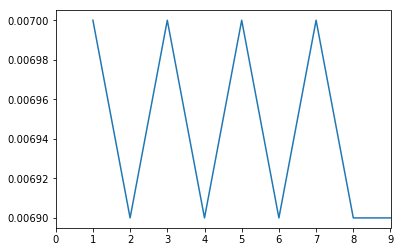

In [12]:
# illustrates variations in drifter time steps
df.sort_values('time').reset_index()['time'].diff().iloc[:10].plot()
df.sort_values('time').reset_index()['time'].diff().mean(axis=0)*24*60

---

## compute lagged autocorrelations

In [9]:
# myfun = correlate
from scipy import signal
def correlate(v1, v2, N, detrend = False, dt=None):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not Provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    if dt is None:
        dt = v1.reset_index()['index'].diff().mean()
    
    if v1 is None and v2 is None:
        _v1 = np.random.randn(N*2)
        _v2 = np.random.randn(N*2)
        if detrend:
            pass
        vv = np.correlate(_v1, _v2, mode='same')
    else:
        if detrend:
            v1 = signal.detrend(v1)
            v2 = signal.detrend(v2)
        
        #print('!!! Not implemented yet')
        # https://www.machinelearningplus.com/time-series/time-series-analysis-python/
        
        vv = np.correlate(v1, v2, mode='same')
    return pd.Series(vv[int(vv.size/2):][:N], index=np.arange(N)*dt)

In [10]:
# inputs: time window and step
T = 20 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50

In [12]:
# apply to one drifter
out = cdr.time_window_processing(df, correlate, ['u','u'], T, int(T/dt/2),L,dt=dt)
out

,x,y,id,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,0.041666666666666664,...,9.930555555555555,9.9375,9.944444444444445,9.951388888888888,9.958333333333332,9.965277777777777,9.972222222222221,9.979166666666666,9.98611111111111,9.993055555555555
1510.0069,1022.866620,1942.883560,225.0,65.251869,65.177638,65.013483,64.760598,64.420893,63.996975,63.492120,...,7.863769,7.845620,7.827826,7.810430,7.793617,7.777455,7.762074,7.747558,7.733979,7.721396
1520.0069,945.092028,1953.198851,225.0,47.232007,47.084827,46.656915,45.951732,44.974970,43.734547,42.240565,...,-7.380873,-8.143376,-8.811782,-9.380902,-9.846278,-10.204342,-10.452347,-10.588415,-10.611556,-10.521676
1530.0069,930.432523,1974.050691,225.0,66.227718,65.944984,65.349707,64.447026,63.244496,61.752081,59.982086,...,-5.357273,-5.042035,-4.718391,-4.389179,-4.057250,-3.725420,-3.396444,-3.073052,-2.757811,-2.453213
1540.0069,1012.620378,1995.372894,225.0,99.107861,98.961982,98.533658,97.826896,96.848221,95.606576,94.113217,...,20.439486,20.177057,19.891455,19.584442,19.257886,18.913774,18.554453,18.182285,17.799725,17.409376
1550.0069,96.897904,1952.648187,225.0,81.597356,81.310837,80.713881,79.812500,78.615722,77.135373,75.385877,...,16.010823,15.934369,15.806114,15.624658,15.391974,15.109469,14.778959,14.402642,13.983073,13.523118
1560.0069,157.918396,1953.855647,225.0,55.384985,55.230151,54.837984,54.213168,53.361381,52.290362,51.009768,...,12.036691,11.537153,11.009619,10.457756,9.885327,9.296136,8.694093,8.083159,7.467371,6.850908
1570.0069,239.144614,1976.728432,225.0,90.560978,90.351021,89.741572,88.738504,87.351371,85.593129,83.480054,...,-0.036528,0.319496,0.678451,1.038236,1.396776,1.752031,2.102004,2.444699,2.778175,3.100491
1580.0069,288.544081,1884.823073,225.0,84.510859,84.193956,83.395010,82.121303,80.384586,78.201207,75.590215,...,12.234099,11.842708,11.277649,10.543371,9.645980,8.592904,7.393016,6.056390,4.594302,3.019128
1590.0069,349.592708,1808.957312,225.0,187.134880,186.902200,186.314637,185.378343,184.102633,182.500245,180.587114,...,21.659102,22.022945,22.337798,22.599778,22.805397,22.951632,23.035908,23.056345,23.011385,22.900045
1600.0069,548.147290,1662.938952,225.0,399.746794,399.385484,398.407490,396.823049,394.648886,391.907818,388.627587,...,157.865971,158.221405,158.514142,158.741680,158.902148,158.994190,159.016673,158.969019,158.851204,158.663840


### map the computation for each drifter

In [13]:
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
df_chunked = dr.df.groupby(['id']).apply(cdr.time_window_processing,
                                         correlate, ['u','u'], T, int(T/dt/2),L, detrend=True,dt=dt
                                        )
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )

# show one partition:
#df_chunked.get_partition(0).compute()

# bin along y and sum
y_bins = np.arange(0,2800,binsize)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
uu = df_chunked.groupby(['y_cut']).sum().compute()

# inspect df_chunked
df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [ ]:
uu.set_index(uu.index.map(lambda v: v.mid))

In [70]:
# transform into 2D xarray
# column header need to be transformed into indices
ds = (pd.melt(uu.set_index(uu.index.map(lambda v: v.mid))
              .drop(columns=['id','time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='lag')
      .rename(columns={'y_cut': 'y_bins', 'value': 'uu'})
      .set_index(['y_bins','lag'])
      .to_xarray()
     )

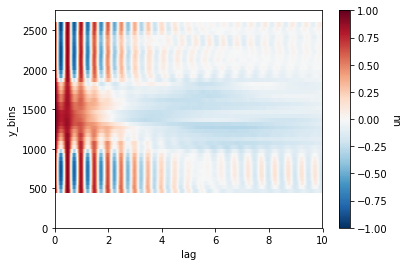

In [47]:
#Normalized autocorrelation 
(ds['uu']/ds['uu'].sel(lag=0.)).plot()

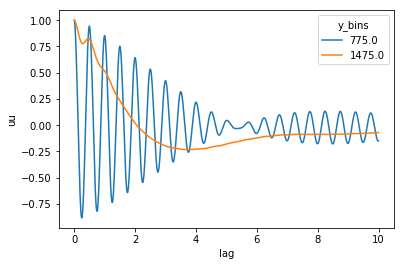

In [50]:
#Autocorrelation at 2 different y : 
#(ds['uu']/ds['uu'].sel(lag=0.)).sel(y_bins=600, method='nearest').plot.line(x='lag')
(ds['uu']/ds['uu'].sel(lag=0.)).isel(y_bins=[15,29]).plot.line(x='lag')

In [18]:
ds.attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'detrend':'linear'}

In [ ]:
#Save data in nc file
#name = 'Lcorr_'+str(T)
#ds.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---
## compute spectra

In [9]:
from scipy import signal

def get_spectrum(v, N, dt=None, method='welch', detrend='linear', **kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v: ndarray, pd.Series
            Time series, the index must be time if dt is not provided
            
        N: int
            Length of the output
            
        dt: float, optional
            Time step
        
        method: string
            Method that will be employed for spectral calculations.
            Default is 'welch'
            
        detrend: boolean, optional
            Turns detrending on or off. Default is 'linear'.

    See: 
        - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html
        - https://krischer.github.io/mtspec/
        - http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    '''
    if v is None:
        _v = np.random.randn(N)
    else:
        _v = v.iloc[:N]
    if dt is None:
        dt = _v.reset_index()['index'].diff().mean()
    if detrend and not method=='welch':
        print('!!! Not implemented yet except for welch')    
    if method=='welch':
        dkwargs = {'window': 'hann', 'return_onesided': False, 
                   'detrend': 'linear', 'scaling': 'density'}
        dkwargs.update(kwargs)
        f, E = signal.periodogram(_v, fs=1/dt, axis=0, **dkwargs)
    elif method=='mtspec':
        lE, f = mtspec(data=_v, delta=dt, time_bandwidth=4.,
                       number_of_tapers=6, quadratic=True)
    elif method=='mt':
        dkwargs = {'NW': 2, 'sides': 'twosided', 
                   'adaptive': False, 'jackknife': False}
        dkwargs.update(kwargs)
        lf, E, nu = tsa.multi_taper_psd(_v, Fs=1/dt, **dkwargs)
        f = fftfreq(len(lf))*24.
        #print('Number of tapers = %d' %(nu[0]/2))
    return pd.Series(E, index=f)

In [10]:
dr.df['ui'] = dr.df.u+1j*dr.df.v

In [ ]:
# run computation over the whole dateset
T=20
dt = 10./60./24
df_chunked = apply_twin_processing(dr, get_spectrum, ['ui'], T, int(T/dt/2), dt=dt)

# bin sum
y_bins = np.arange(0,2800,30)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
Eu = df_chunked.groupby(['y_cut']).mean().compute()

ds_ft = (pd.melt(Eu.set_index(Eu.index.map(lambda v: v.mid))
              .drop(columns=['time','x','y'])
              .reset_index()
            , id_vars=['y_cut'], var_name='frequency')
      .rename(columns={'y_cut': 'y_bins', 'value': 'Eu'})
      .set_index(['y_bins','frequency'])
      .to_xarray()
     )



/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.


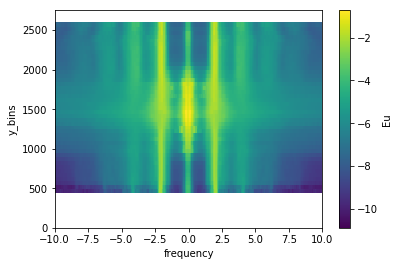

In [36]:
np.log10(ds.Eu).plot(x='frequency',y='y_bins',xlim=(-10,10))

Text(0,0.5,'Power spectral density')

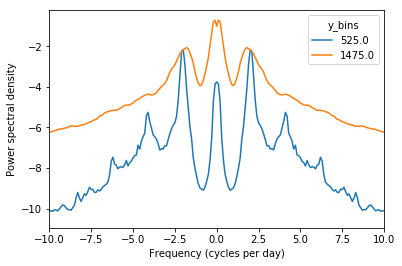

In [24]:
#Plot KE spectra for 2 y : 

np.log10(ds_ft.Eu.isel(y_bins=[10,29])).plot.line(x='frequency', xlim=(-10,10))
plt.xlabel('Frequency (cycles per day)');plt.ylabel('Power spectral density')

In [ ]:
#Save data in nc file
#name = 'Lspectra_'+str(T)+'.nc'
#ds_ft.to_netcdf(path = '/home1/datawork/zcaspar/diags/'+name)

---

In [ ]:
cluster.close()